In [1]:
# imports

import json
import os
import re
import sqlite3
import emoji
import statsmodels

import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sqlite3 import Error
from datetime import datetime
from tqdm import tqdm
from datasets import Dataset

/Users/alexraudvee/Desktop/final_code_DBL_group24/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Preparing the data for analysis

In [10]:
db_name = '/Users/alexraudvee/Downloads/tweets_final.db' # loading the data
json_name = "/Users/alexraudvee/Downloads/updated_convs.json"

conv_df = pd.read_json(json_name)


avia_companies = {'KLM': 56377143, 'AirFrance': 106062176, 'British_Airways': 18332190, 'AmericanAir': 22536055,
                  'Lufthansa': 124476322, 'AirBerlin': 26223583,
                  'AirBerlin assist': 2182373406, 'easyJet': 38676903, 'RyanAir': 1542862735, 'SingaporeAir': 253340062,
                  'Qantas': 218730857, 'EtihadAirways': 45621423,
                  'VirginAtlantic': 20626359}

In [11]:
reverse_avia_companies={}
for key in avia_companies.keys():
    reverse_avia_companies[avia_companies[key]]=key

reverse_avia_companies

{56377143: 'KLM',
 106062176: 'AirFrance',
 18332190: 'British_Airways',
 22536055: 'AmericanAir',
 124476322: 'Lufthansa',
 26223583: 'AirBerlin',
 2182373406: 'AirBerlin assist',
 38676903: 'easyJet',
 1542862735: 'RyanAir',
 253340062: 'SingaporeAir',
 218730857: 'Qantas',
 45621423: 'EtihadAirways',
 20626359: 'VirginAtlantic'}

In [12]:
def create_connection(db_file):
    """ create a database connection to a SQLite database """
    conn = None
    try:
        
        conn = sqlite3.connect(db_file)
        print(sqlite3.version)
    except Error as e:
        print(e)
    return conn

In [13]:
try:
     
    # Making a connection between sqlite3
    # database and Python Program
    sqliteConnection = sqlite3.connect(db_name)
     
    # If sqlite3 makes a connection with python
    # program then it will print "Connected to SQLite"
    # Otherwise it will show errors
    print("Connected to SQLite")
 
    # Getting all tables from sqlite_master
    sql_query = """SELECT name FROM sqlite_master
    WHERE type='table';"""
 
    # Creating cursor object using connection object
    cursor = sqliteConnection.cursor()
     
    # executing our sql query
    cursor.execute(sql_query)
    print("List of tables\n")
     
    # printing all tables list
    print(cursor.fetchall())
 
except sqlite3.Error as error:
    print("Failed to execute the above query", error)
     
finally:
   
    # Inside Finally Block, If connection is
    # open, we need to close it
    if sqliteConnection:
         
        # using close() method, we will close
        # the connection
        sqliteConnection.close()
         
        # After closing connection object, we
        # will print "the sqlite connection is
        # closed"
        print("the sqlite connection is closed")

Connected to SQLite
List of tables

[('users',), ('tweets',), ('tweets_geo',), ('replies',), ('retweets',), ('quotes',), ('hashtags',), ('sqlite_sequence',), ('symbols',), ('user_mentions',), ('urls',)]
the sqlite connection is closed


In [14]:
cnx = create_connection(db_name)

2.6.0


In [15]:
users = pd.read_sql_query("SELECT * FROM users", cnx)
tweets = pd.read_sql_query("SELECT * FROM tweets", cnx)
tweets_geo = pd.read_sql_query("SELECT * FROM tweets_geo", cnx)
replies = pd.read_sql_query("SELECT * FROM replies", cnx)
retweets = pd.read_sql_query("SELECT * FROM retweets", cnx)
quotes = pd.read_sql_query("SELECT * FROM quotes", cnx)
hashtags = pd.read_sql_query("SELECT * FROM hashtags", cnx)
sqlite_sequence = pd.read_sql_query("SELECT * FROM sqlite_sequence", cnx)
symbols = pd.read_sql_query("SELECT * FROM symbols", cnx)
user_mentions = pd.read_sql_query("SELECT * FROM user_mentions", cnx)

In [16]:
conv_df

,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff
0,0,1662186764,1131173010508062721,Thanks @British_Airways I really needed the ex...,2019-05-22 12:20:36.540,18332190,2019-05-22 12:20:36.540,negative,0,NaN
1,0,18332190,1131175995321520128,@sunriseblade That certainly is annoying. Hope...,2019-05-22 12:32:28.175,18332190,2019-05-22 12:32:28.175,negative,711635,NaN
2,0,1662186764,1131180010230951942,"@British_Airways I wish, we're getting off the...",2019-05-22 12:48:25.404,18332190,2019-05-22 12:48:25.404,positive,957229,2.0
3,0,18332190,1131316435748360192,@sunriseblade We're pleased to hear the crew d...,2019-05-22 21:50:31.782,18332190,2019-05-22 21:50:31.782,positive,32526378,NaN
4,0,1662186764,1131319965854965760,@British_Airways BA460,2019-05-22 22:04:33.425,18332190,2019-05-22 22:04:33.425,neutral,841643,-1.0
...,...,...,...,...,...,...,...,...,...,...
1040225,388307,23849698,1244695647271485448,@VirginAtlantic Booked at one of the Virgin st...,2020-03-30 18:39:02.293,20626359,2020-03-30 18:39:02.293,neutral,24929,0.0
1040226,388308,38297237,1244692572225896449,I cannot say enough good things about @VirginA...,2020-03-30 18:26:49.145,20626359,2020-03-30 18:26:49.145,positive,0,NaN
1040227,388308,20626359,1244694313407217665,@jenndeavors Hi Jenn. Thats great to hear. Tha...,2020-03-30 18:33:44.275,20626359,2020-03-30 18:33:44.275,positive,415130,NaN
1040228,388309,22536055,1244695110639632386,@misubisumisu We've sent you a DM with a message.,2020-03-30 18:36:54.350,22536055,2020-03-30 18:36:54.350,neutral,0,NaN


In [17]:
def from_Timestamp_to_datetime_str(Timestamp):
    """
    the input should be: Timestamp(any)
    returns date as string: 'year-mont-day'
    """

    date_time = Timestamp.to_pydatetime().strftime('%Y-%m-%d')

    return date_time


def from_Timestamp_to_timestamp_int(Timestamp):
    """
    The input should be: Timestamp(any)
    Returns timestamp integer
    """

    timestamp_int = int(Timestamp.timestamp())

    return timestamp_int


def from_datetime_str_to_timestamp_int(date_str: str):
    """
    The input should be: 'year-mont-day'
    Returns timestamp integer
    """

    date = datetime.strptime(date_str, '%Y-%m-%d')
    timestamp_int = int(date.timestamp())

    return timestamp_int

In [18]:
conv_df['timestamp'] = conv_df['timestamp'].apply(from_Timestamp_to_datetime_str)
conv_df['timestamp'] = conv_df['timestamp'].apply(from_datetime_str_to_timestamp_int)


In [19]:
conv_len = {}
for conv_id in conv_df['conv_id']:
    conv_len[conv_id] = conv_len.get(conv_id, 0) + 1

len(conv_len)

388310

In [20]:
used_id_lst = [] # list with all ids used for response anaalysis
for key in conv_len.keys():
    if conv_len[key] > 2:
        used_id_lst.append(key)
    
        
intresting = (len(conv_len), len(conv_len) - len(used_id_lst), len(used_id_lst)) 
# first value =  number of all coversations
# third value = number of all conversations with only to messages
# thirs value = number of convesations that have more than 2 meassgaes
intresting

(388310, 255151, 133159)

In [21]:
used_df = pd.DataFrame() # data frem with all necesary data for conversation and response time analysis
                         # a backbone of this part of code
    
used_df = used_df.append(conv_df[conv_df['conv_id'].isin(used_id_lst)])

used_df

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3004254509.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  used_df = used_df.append(conv_df[conv_df['conv_id'].isin(used_id_lst)])


,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff
0,0,1662186764,1131173010508062721,Thanks @British_Airways I really needed the ex...,1558476000,18332190,2019-05-22 12:20:36.540,negative,0,NaN
1,0,18332190,1131175995321520128,@sunriseblade That certainly is annoying. Hope...,1558476000,18332190,2019-05-22 12:32:28.175,negative,711635,NaN
2,0,1662186764,1131180010230951942,"@British_Airways I wish, we're getting off the...",1558476000,18332190,2019-05-22 12:48:25.404,positive,957229,2.0
3,0,18332190,1131316435748360192,@sunriseblade We're pleased to hear the crew d...,1558476000,18332190,2019-05-22 21:50:31.782,positive,32526378,NaN
4,0,1662186764,1131319965854965760,@British_Airways BA460,1558476000,18332190,2019-05-22 22:04:33.425,neutral,841643,-1.0
...,...,...,...,...,...,...,...,...,...,...
1040219,388305,2729018082,1244693802532601856,"@VirginAtlantic It is a complete package, flig...",1585519200,20626359,2020-03-30 18:31:42.473,neutral,242434,0.0
1040220,388305,20626359,1244694687514071041,@MalcolmCraik Hi Malcolm All our package holid...,1585519200,20626359,2020-03-30 18:35:13.469,neutral,210996,NaN
1040223,388307,23849698,1244692213369577473,"@VirginAtlantic Hi, I have a holiday booked wi...",1585519200,20626359,2020-03-30 18:25:23.587,neutral,0,NaN
1040224,388307,20626359,1244695542711693312,@SallyJDavies Hi Sally. Can I just confirm who...,1585519200,20626359,2020-03-30 18:38:37.364,neutral,793777,NaN


In [22]:
conv_len_check = {}
for conv_id in used_df['conv_id']:
    conv_len_check[conv_id] = conv_len.get(conv_id, 0) + 1

len(conv_len_check.keys()) # just double checking if everything works

133159

In [23]:
c_first = [] # list with converstion ids where company starts 
u_first = [] # list with converstion ids where user starts 

for index, rows in used_df[used_df['time_taken'] == 0].iterrows():
    if rows['user_id'] in list(avia_companies.values()):
        c_first.append(rows['conv_id'])
    else:
        u_first.append(rows['conv_id'])
    


In [24]:
len(c_first), len(u_first)

(9465, 123694)

# A) Difference in sentiment in conversation

## Spliting and preparing data for difference in sentiment and response time 

In [25]:
userf_diff_df = pd.DataFrame()
compf_diff_df = pd.DataFrame()

userf_diff_df = userf_diff_df.append(used_df[used_df['conv_id'].isin(u_first)])
compf_diff_df = compf_diff_df.append(used_df[used_df['conv_id'].isin(c_first)])

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/903882821.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  userf_diff_df = userf_diff_df.append(used_df[used_df['conv_id'].isin(u_first)])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/903882821.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compf_diff_df = compf_diff_df.append(used_df[used_df['conv_id'].isin(c_first)])


In [26]:
len(userf_diff_df) + len(compf_diff_df) == len(used_df) #just checking if everything is fine

True

### Data where user starts conversation (difference in sentiment)

In [27]:
userf_diff_df['time_shift'] = userf_diff_df['time_taken'].shift(1)

In [28]:
userf_diff_df.drop(userf_diff_df[userf_diff_df['time_taken'] == 0].index, inplace = True)

In [29]:
userf_diff_df.drop(userf_diff_df[userf_diff_df['user_id'].isin(list(avia_companies.values()))].index, inplace = True)

In [30]:
userf_diff_df.head()

,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff,time_shift
2,0,1662186764,1131180010230951942,"@British_Airways I wish, we're getting off the...",1558476000,18332190,2019-05-22 12:48:25.404,positive,957229,2.0,711635.0
4,0,1662186764,1131319965854965760,@British_Airways BA460,1558476000,18332190,2019-05-22 22:04:33.425,neutral,841643,-1.0,32526378.0
18,6,80875149,1131833139561607169,@SingaporeAir well since in Aug-19 you are not...,1558648800,253340062,2019-05-24 08:03:43.571,negative,154225201,0.0,2401391.0
20,6,80875149,1131886960471973889,@SingaporeAir So you what you mean is it is @a...,1558648800,253340062,2019-05-24 11:37:35.476,negative,9746988,0.0,3084917.0
26,8,22672731,1131185419163447296,@VirginAtlantic No. We paid for the bubble 11 ...,1558476000,20626359,2019-05-22 13:09:54.994,negative,675916,0.0,1364459.0


### Data where comapny starts conversation (difference in sentiment)

In [31]:
compf_diff_df['time_shift'] = compf_diff_df['time_taken'].shift(1)

In [32]:
compf_diff_df.drop(compf_diff_df[compf_diff_df['user_id'].isin(list(avia_companies.values()))].index, inplace = True)

In [33]:
compf_diff_df.drop(compf_diff_df[compf_diff_df['time_shift'] == 0].index, inplace = True)

In [34]:
compf_diff_df.head()

,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff,time_shift
2760,993,3188617812,1131543839980658695,"@EtihadAirways WARMLY RECIPROCATED ,,,,IT IS I...",1558562400,45621423,2019-05-23 12:54:09.176,positive,4479884,0.0,124158.0
3368,1219,24086519,1131567589111603205,@British_Airways Leanne I'm not flying until A...,1558562400,18332190,2019-05-23 14:28:31.410,positive,468792,0.0,3349564.0
3378,1223,24086519,1131567231882735622,@British_Airways I've already purchased my tic...,1558562400,18332190,2019-05-23 14:27:06.240,negative,383622,-2.0,3349564.0
3903,1425,3102280380,1131663907372843008,@AmericanAir Pieces of shit. Send a “rebook” D...,1558562400,22536055,2019-05-23 20:51:15.473,negative,1077880,0.0,4695983.0
4688,1699,2696291841,1131843236891418624,@Ryanair Thx 👍😀,1558648800,1542862735,2019-05-24 08:43:50.962,positive,8707507,1.0,36496236.0


### Creating data frame for analysis of difference in sentiment in conversation affected by response time

In [35]:
users_resp_df = pd.concat([compf_diff_df,userf_diff_df])

In [36]:
merged_diff_df = users_resp_df

In [28]:
# replies = replies.rename(columns={'reply_id': 'tweet_id'})

In [29]:
# merged_diff_df = users_resp_df.merge(replies, on='tweet_id', how='left')

In [30]:
# merged_diff_df['reply_to_user_id'].isna().sum() # everthying is fine :D

In [31]:
# merged_diff_df = merged_diff_df.drop(['reply_to_status_id'], axis=1)

In [37]:
def getting_company(ids):
    label = reverse_avia_companies[ids]
    return(label)

In [38]:
# merged_diff_df['reply_to_label'] = merged_diff_df['reply_to_user_id'].apply(getting_company)
merged_diff_df['reply_to_label'] = merged_diff_df['for_airline_id'].apply(getting_company)


In [39]:
merged_diff_df['label_sentiment_diff'] = '' # we label sentiment diffrence score, because it makes it easier to work with


for index, row in merged_diff_df.iterrows():
    if row['sentiment_diff'] == 0 and row['sentiment_label'] == 'positive':
        merged_diff_df.at[index, 'label_sentiment_diff'] = "+0"
        
    if row['sentiment_diff'] == 0 and row['sentiment_label'] == 'negative':
        merged_diff_df.at[index, 'label_sentiment_diff'] = "-0"
        
    if row['sentiment_diff'] == 0 and row['sentiment_label'] == 'neutral':
        merged_diff_df.at[index, 'label_sentiment_diff'] = "0"
        
    if row['sentiment_diff'] == 2:
        merged_diff_df.at[index, 'label_sentiment_diff'] = "neg_pos"
        
    if row['sentiment_diff'] == -2:
        merged_diff_df.at[index, 'label_sentiment_diff'] = "pos_neg"

    if row['sentiment_diff'] == 1:
        merged_diff_df.at[index, 'label_sentiment_diff'] = "neu_pos"
        
    if row['sentiment_diff'] == -1:
        merged_diff_df.at[index, 'label_sentiment_diff'] = "neu_neg"

In [40]:
merged_diff_df# data frame with only user responses to companies tweets; also cosiders the time that the company needed 
          # to respond

,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff,time_shift,reply_to_label,label_sentiment_diff
2760,993,3188617812,1131543839980658695,"@EtihadAirways WARMLY RECIPROCATED ,,,,IT IS I...",1558562400,45621423,2019-05-23 12:54:09.176,positive,4479884,0.0,124158.0,EtihadAirways,+0
3368,1219,24086519,1131567589111603205,@British_Airways Leanne I'm not flying until A...,1558562400,18332190,2019-05-23 14:28:31.410,positive,468792,0.0,3349564.0,British_Airways,+0
3378,1223,24086519,1131567231882735622,@British_Airways I've already purchased my tic...,1558562400,18332190,2019-05-23 14:27:06.240,negative,383622,-2.0,3349564.0,British_Airways,pos_neg
3903,1425,3102280380,1131663907372843008,@AmericanAir Pieces of shit. Send a “rebook” D...,1558562400,22536055,2019-05-23 20:51:15.473,negative,1077880,0.0,4695983.0,AmericanAir,-0
4688,1699,2696291841,1131843236891418624,@Ryanair Thx 👍😀,1558648800,1542862735,2019-05-24 08:43:50.962,positive,8707507,1.0,36496236.0,RyanAir,neu_pos
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040202,388298,957807812,1244690555864522759,@KLM Ik wil namelijk niet dat mijn voucher nu ...,1585519200,56377143,2020-03-30 18:18:48.407,negative,195441,0.0,864252.0,KLM,-0
1040205,388299,1129591998153990146,1244693863102590978,@AmericanAir Thank you.,1585519200,22536055,2020-03-30 18:31:56.914,positive,78287,2.0,1587498.0,AmericanAir,neg_pos
1040216,388304,2729018082,1244695187529629696,@VirginAtlantic Ok thanks very much.,1585519200,20626359,2020-03-30 18:37:12.682,positive,572643,1.0,515009.0,VirginAtlantic,neu_pos
1040219,388305,2729018082,1244693802532601856,"@VirginAtlantic It is a complete package, flig...",1585519200,20626359,2020-03-30 18:31:42.473,neutral,242434,0.0,515009.0,VirginAtlantic,0


In [41]:
merged_diff_df.groupby(['reply_to_label','label_sentiment_diff'])['tweet_id'].count()

reply_to_label  label_sentiment_diff
AirFrance       +0                        61
                -0                      1335
                0                        473
                neg_pos                  296
                neu_neg                  353
                                        ... 
easyJet         0                       2706
                neg_pos                 2218
                neu_neg                 2874
                neu_pos                 6545
                pos_neg                  525
Name: tweet_id, Length: 77, dtype: int64

### Spliting merged_diff_df per flying company

In [42]:
# data frame with users responses to AirFrance
AirFrance_df = pd.DataFrame()

AirFrance_df = AirFrance_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'AirFrance'])

len(AirFrance_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/1312063049.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AirFrance_df = AirFrance_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'AirFrance'])


3529

In [43]:
# data frame with users responses to AmericanAir
AmericanAir_df = pd.DataFrame()

AmericanAir_df = AmericanAir_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'AmericanAir'])

len(AmericanAir_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3559519510.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  AmericanAir_df = AmericanAir_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'AmericanAir'])


45048

In [44]:
# data frame with users responses to British_Airways
BritishAirways_df = pd.DataFrame()

BritishAirways_df = BritishAirways_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'British_Airways'])

len(BritishAirways_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/1248193533.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  BritishAirways_df = BritishAirways_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'British_Airways'])


44359

In [45]:
# data frame with users responses to EtihadAirways
EtihadAirways_df = pd.DataFrame()

EtihadAirways_df = EtihadAirways_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'EtihadAirways'])

len(EtihadAirways_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/2284796551.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  EtihadAirways_df = EtihadAirways_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'EtihadAirways'])


448

In [46]:
# data frame with users responses to KLM
KLM_df = pd.DataFrame()

KLM_df = KLM_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'KLM'])

len(KLM_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/471317614.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  KLM_df = KLM_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'KLM'])


15420

In [47]:
# data frame with users responses to Lufthansa
Lufthansa_df = pd.DataFrame()

Lufthansa_df = Lufthansa_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'Lufthansa'])

len(Lufthansa_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/1026958963.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Lufthansa_df = Lufthansa_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'Lufthansa'])


8143

In [48]:
# data frame with users responses to Qantas
Qantas_df = pd.DataFrame()

Qantas_df = Qantas_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'Qantas'])

len(Qantas_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3377236179.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Qantas_df = Qantas_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'Qantas'])


3470

In [49]:
# data frame with users responses to RyanAir
RyanAir_df = pd.DataFrame()

RyanAir_df = RyanAir_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'RyanAir'])

len(RyanAir_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3030051098.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RyanAir_df = RyanAir_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'RyanAir'])


7252

In [50]:
# data frame with users responses to SingaporeAir
SingaporeAir_df = pd.DataFrame()

SingaporeAir_df = SingaporeAir_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'SingaporeAir'])

len(SingaporeAir_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/2562374982.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  SingaporeAir_df = SingaporeAir_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'SingaporeAir'])


6710

In [51]:
# data frame with users responses to VirginAtlantic
VirginAtlantic_df = pd.DataFrame()

VirginAtlantic_df = VirginAtlantic_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'VirginAtlantic'])

len(VirginAtlantic_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/1881969411.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  VirginAtlantic_df = VirginAtlantic_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'VirginAtlantic'])


9504

In [52]:
# data frame with users responses to easyJet
easyJet_df = pd.DataFrame()

easyJet_df = easyJet_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'easyJet'])

len(easyJet_df)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/2926677820.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  easyJet_df = easyJet_df.append(merged_diff_df[merged_diff_df['reply_to_label'] == 'easyJet'])


24222

In [53]:
eureka = merged_diff_df.groupby(['reply_to_label', 'label_sentiment_diff'])[['label_sentiment_diff']].count()

In [54]:
eureka.loc['easyJet']
eureka.loc['British_Airways']

,label_sentiment_diff
label_sentiment_diff,
+0,1717
-0,16525
0,4470
neg_pos,4074
neu_neg,4994
neu_pos,11550
pos_neg,1029


In [55]:
AirFrance_df.groupby(['label_sentiment_diff']).count()

,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff,time_shift,reply_to_label
label_sentiment_diff,,,,,,,,,,,,
+0,61,61,61,61,61,61,61,61,61,61,61,61
-0,1335,1335,1335,1335,1335,1335,1335,1335,1335,1335,1335,1335
0,473,473,473,473,473,473,473,473,473,473,473,473
neg_pos,296,296,296,296,296,296,296,296,296,296,296,296
neu_neg,353,353,353,353,353,353,353,353,353,353,353,353
neu_pos,956,956,956,956,956,956,956,956,956,956,956,956
pos_neg,55,55,55,55,55,55,55,55,55,55,55,55


### Creating data frame used for visualisations

In [56]:
def get_change(df):
    # function returns a dictionary with number of each sentiment change for every company
    # 0's say that sentiment between previous and current user's messages hasn't changed, however we distinguished between
    # -0 staying negative, +0 staying positive, 0 staying neitral
    # neg_pos best outcome form previous negative message we got positive response
    # pos_neg worst outcome from previous positive message we got negative response
    #N
    try: 
    
        name = df['reply_to_label'].iloc[0]
        
        stays_positive = df['label_sentiment_diff'].value_counts()['+0']
        stays_negative = df['label_sentiment_diff'].value_counts()['-0']
        stays_neutral = df['label_sentiment_diff'].value_counts()['0']
        
        neg_pos = df['label_sentiment_diff'].value_counts()['neg_pos']
        neu_pos = df['label_sentiment_diff'].value_counts()['neu_pos']
        
        pos_neg = df['label_sentiment_diff'].value_counts()['pos_neg']
        neu_neg = df['label_sentiment_diff'].value_counts()['neu_neg']
        

        improvemnt = stays_positive +  neg_pos + neu_pos

        decline = stays_negative + pos_neg + neu_neg

        sent_change = {"name":name, "neg_pos":neg_pos, "neu_pos": neu_pos, "+0":stays_positive, "0":stays_neutral, 
                      "-0":stays_negative, "neu_neg": neu_neg, "pos_neg":pos_neg, "improvemnt":improvemnt, "decline":decline}

        return sent_change
            
            
    
    except: 
        
        return None

In [57]:
random = pd.DataFrame()


responses_lst = [AirFrance_df, AmericanAir_df, 
                 BritishAirways_df, EtihadAirways_df,
                KLM_df, Lufthansa_df, Qantas_df, RyanAir_df,
                SingaporeAir_df, VirginAtlantic_df, easyJet_df, random]

responses_analysis = pd.DataFrame()

for company in responses_lst:
    row = get_change(company)
    responses_analysis = responses_analysis.append(row, ignore_index=True)

responses_analysis = responses_analysis.set_index('name')

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3055073256.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  responses_analysis = responses_analysis.append(row, ignore_index=True)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3055073256.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  responses_analysis = responses_analysis.append(row, ignore_index=True)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3055073256.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  responses_analysis = responses_analysis.append(row, ignore_index=True)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3055073256.py:13: FutureWarning: The frame.append method is deprecat

In [58]:
responses_analysis

,neg_pos,neu_pos,+0,0,-0,neu_neg,pos_neg,improvemnt,decline
name,,,,,,,,,
AirFrance,296,956,61,473,1335,353,55,1313,1743
AmericanAir,4483,10452,1660,2595,20450,4062,1346,16595,25858
British_Airways,4074,11550,1717,4470,16525,4994,1029,17341,22548
EtihadAirways,23,101,80,72,93,68,11,204,172
KLM,1367,4354,1156,2003,4313,1895,332,6877,6540
Lufthansa,591,2240,153,1064,2990,1025,80,2984,4095
Qantas,498,979,215,278,1093,312,95,1692,1500
RyanAir,597,2105,49,1366,2201,872,62,2751,3135
SingaporeAir,423,1931,252,1135,1980,898,91,2606,2969


In [59]:
# responses_analysis = responses_analysis.set_index('name')
df_col = ['neg_pos', 'neu_pos', '+0','0', '-0', 'neu_neg', 'pos_neg', 'improvemnt', 'decline']
responses_analysis = responses_analysis[df_col]


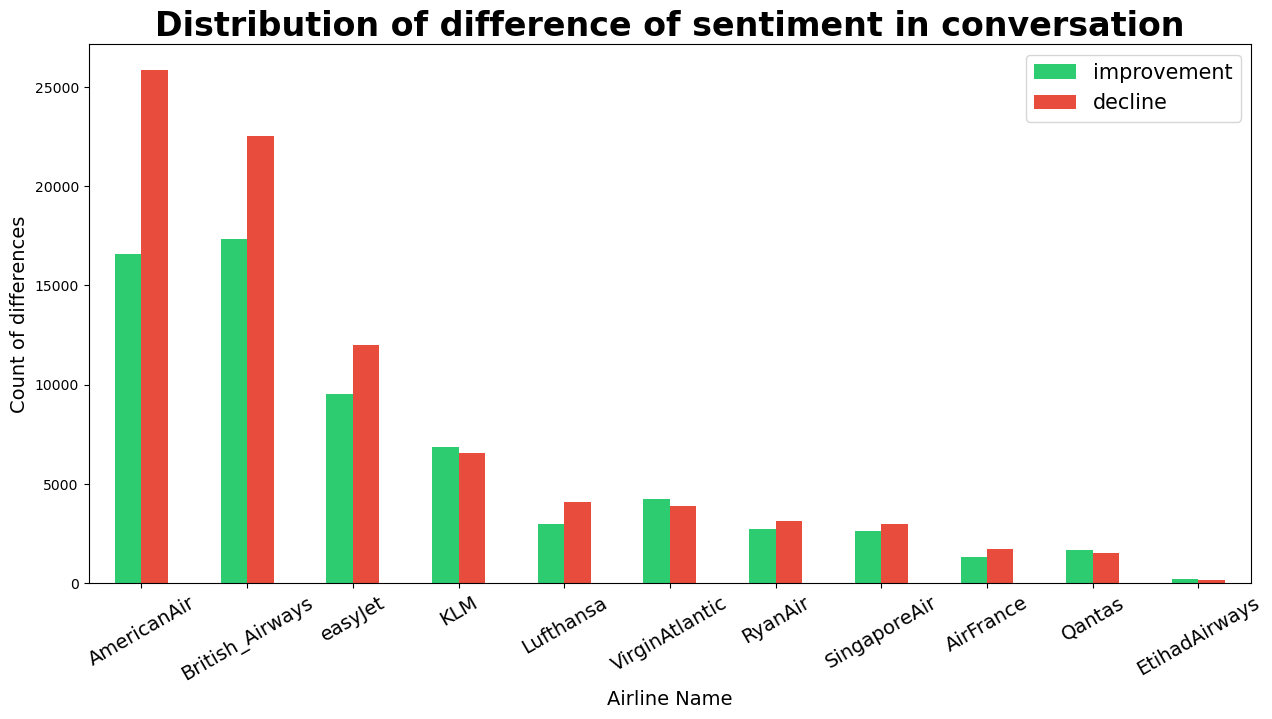

In [60]:
# visualisation of sentiment change per company

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))


bars_grouped = responses_analysis[['improvemnt', 'decline']].sort_values(by = "decline", ascending = False).plot(kind='bar', 
                                                                  ax=ax, color=["#2ECC71", '#E74C3C'])

plt.title("Distribution of difference of sentiment in conversation", size = 24, weight='bold')
# ax.text(x=0.12, y=.93, s="Distribution of difference of sentiment in conversation", 
#         transform=fig.transFigure, ha='left', fontsize=24, weight='bold', alpha=.6)

# x axis 
ax.set_xlabel('Airline Name', size = 14)
plt.xticks(rotation=30, size=14)
plt.legend(["improvement", "decline"], prop = { "size": 15 }, loc ="upper right")

# y axis 
ax.set_ylabel('Count of differences', size=14);

# code for saving
#fig.get_figure().savefig('dist_of_sent_per_airline.png')


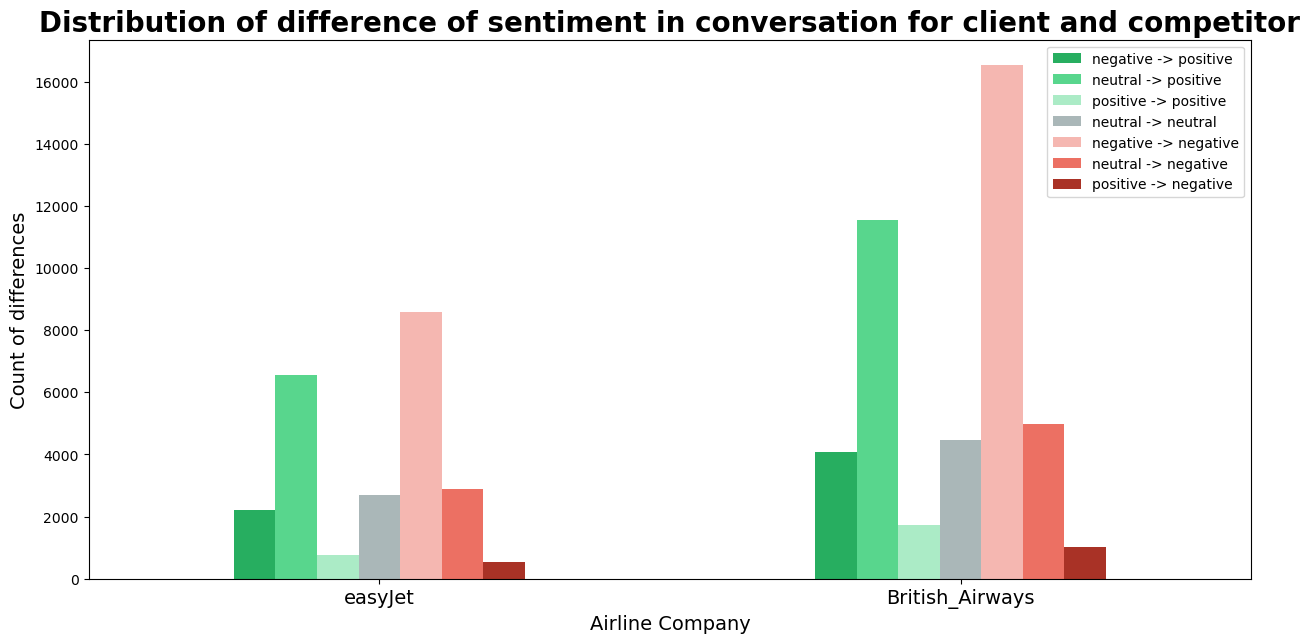

In [61]:
AE_BA_df = responses_analysis.loc[['easyJet', 'British_Airways']]

color = ["#27AE60", "#58D68D", "#ABEBC6", "#AAB7B8" ,"#F5B7B1" ,"#EC7063", "#A93226"]

legend_labels = ["negative -> positive", "neutral -> positive", "positive -> positive", "neutral -> neutral",
                "negative -> negative", "neutral -> negative", "positive -> negative" ]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,7))

complex_bars_grouped = AE_BA_df.iloc[:, 0:7].plot(kind='bar', ax=ax, color=color)

plt.title("Distribution of difference of sentiment in conversation for client and competitor", size = 20, weight='bold')

# ax.text(x=0.09, y=.93, s="Distribution of difference of sentiment in conversation for client and competitor", 
#         transform=fig.transFigure, ha='left', fontsize=20, weight='bold', alpha=.6)

plt.legend(legend_labels, prop = { "size": 10 }, loc ="upper right")

ax.set_xlabel('Airline Company', size = 14)
plt.xticks(rotation=0, size=14)
ax.set_ylabel('Count of differences', size=14);

                                                                                 
                                                                           

# Correlation between response time and sentiment 

### We only check the correlation for our client and competitor


In [62]:
from sklearn.preprocessing import LabelEncoder

In [63]:
cor_EJ_df = easyJet_df[['time_shift', 'label_sentiment_diff']]
cor_BA_df = BritishAirways_df[['time_shift', 'label_sentiment_diff']]

cor_EJ_df['time_shift'] = cor_EJ_df['time_shift'].apply(lambda x: x/3600000) # in hours
cor_BA_df['time_shift'] = cor_BA_df['time_shift'].apply(lambda x: x/3600000)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/880698284.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_EJ_df['time_shift'] = cor_EJ_df['time_shift'].apply(lambda x: x/3600000) # in hours
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/880698284.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_BA_df['time_shift'] = cor_BA_df['time_shift'].apply(lambda x: x/3600000)


In [64]:
encoder = LabelEncoder()

cor_EJ_df['encoded'] = encoder.fit_transform(cor_EJ_df['label_sentiment_diff'])
cor_BA_df['encoded'] = encoder.fit_transform(cor_BA_df['label_sentiment_diff'])

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/1002923634.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_EJ_df['encoded'] = encoder.fit_transform(cor_EJ_df['label_sentiment_diff'])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/1002923634.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cor_BA_df['encoded'] = encoder.fit_transform(cor_BA_df['label_sentiment_diff'])


In [65]:
cor_EJ_df.head()

,time_shift,label_sentiment_diff,encoded
17303,0.066944,neg_pos,3
30249,0.184856,neu_neg,4
73851,0.231265,0,2
74929,0.021513,+0,0
112987,0.142237,-0,1


In [66]:
cor_EJ_df['encoded'].unique()

array([3, 4, 2, 0, 1, 5, 6])

In [67]:
cor_BA_df.head()

,time_shift,label_sentiment_diff,encoded
3368,0.930434,+0,0
3378,0.930434,pos_neg,6
6594,1.925035,neu_pos,5
6598,1.925035,neu_pos,5
6600,0.208535,+0,0


In [68]:
cor_score_EJ = cor_EJ_df['time_shift'].corr(cor_EJ_df['encoded']) # correlation score for easyJet
cor_score_EJ

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


-0.00019626197261990482

In [69]:
cor_score_BA = cor_BA_df['time_shift'].corr(cor_BA_df['encoded']) # correlation score for BritishAirways
cor_score_BA

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


0.013967197694806288

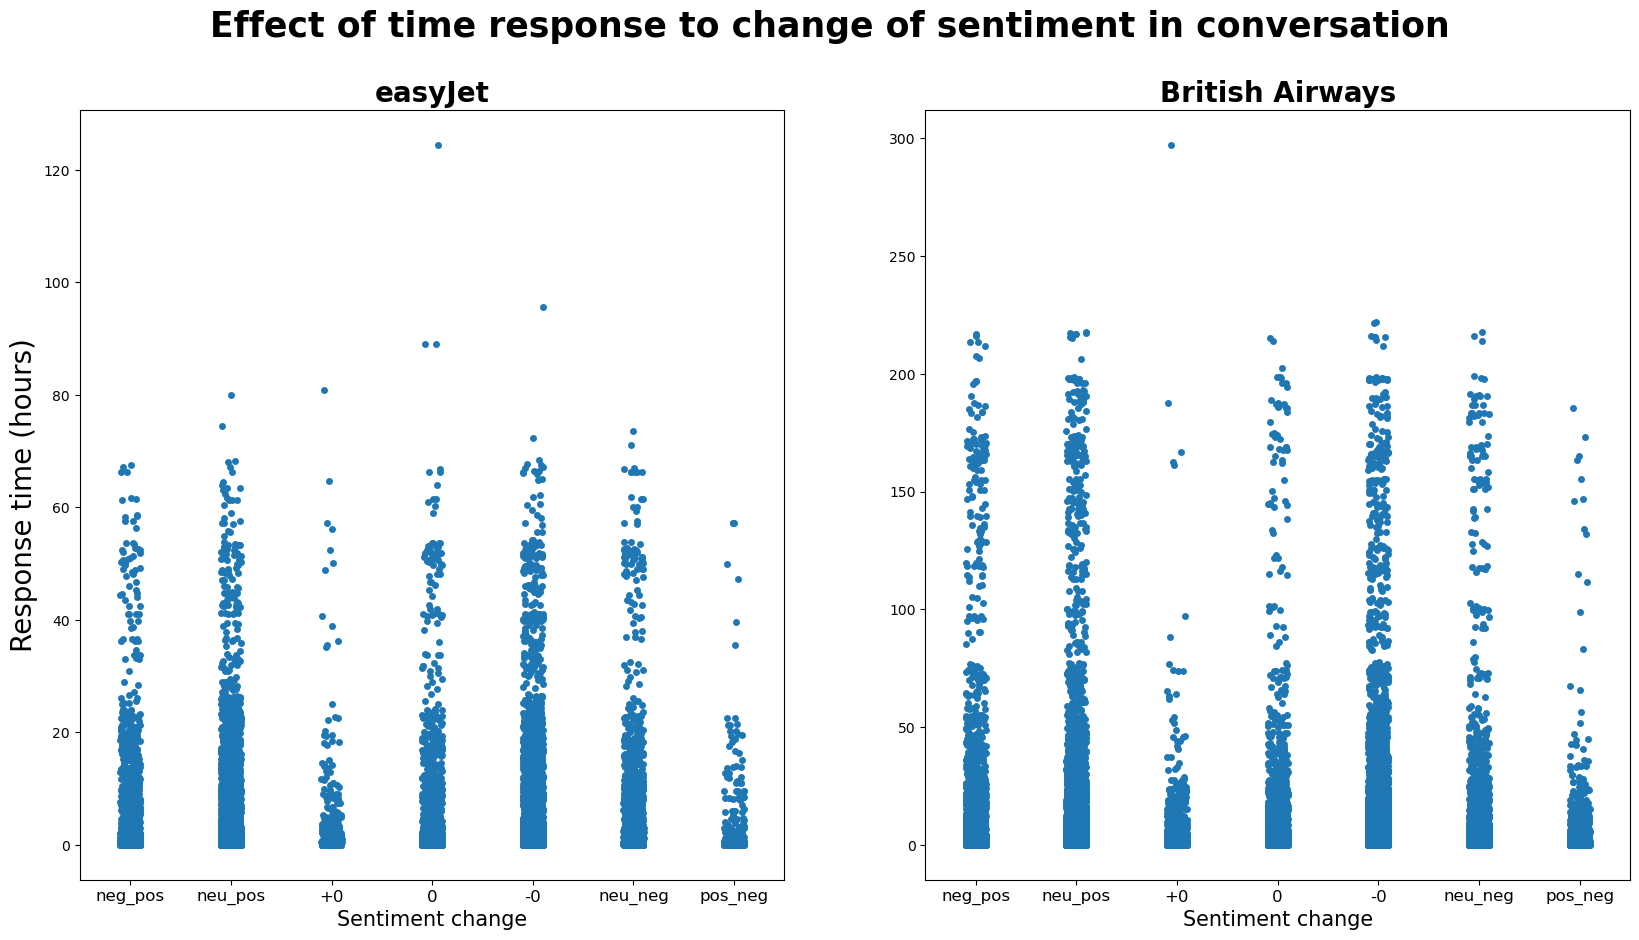

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10)) 

category_order = ["neg_pos", "neu_pos", "+0", "0", "-0", "neu_neg", "pos_neg"] ### delete this line if the visualisation does not work
sns.stripplot(data=cor_EJ_df, x="label_sentiment_diff", y="time_shift", order=category_order, ax=ax[0])
sns.stripplot(data=cor_BA_df, x="label_sentiment_diff", y="time_shift", order=category_order, ax=ax[1])

fig.suptitle('Effect of time response to change of sentiment in conversation', size = 25, weight = "bold")

ax[0].set_title("easyJet", size = 20, weight = "bold")
ax[1].set_title("British Airways", size = 20, weight = "bold")

ax[0].set_ylabel("Response time (hours)", size = 20)
ax[1].set_ylabel("")

ax[0].tick_params(axis='x', labelsize=12)
ax[1].tick_params(axis='x', labelsize=12)

ax[0].set_xlabel("Sentiment change", size=15)
ax[1].set_xlabel("Sentiment change", size=15);



# B) Response time for given topic

## Topic extraction function

In [71]:
# lists with words connected to given topic
comforts = ['seat', 'legroom', 'hotel', 'greed', 'outpricing', 'charged', 'updates', 'website', 'flight experience', 'full price ticket', 'entertainment']
luggages = ['bad', 'luggage', 'baggage', 'handbag', 'belonging', 'suitcase', 'belongings']
punctualitys = ['hour', 'day', 'late', 'waiting', 'delay', 'week', 'home', 'today', 'year', 'tomorrow', 'month', 'morning', 'date', 'night', 'minute', 'queue', 'cancel', 'cancelation', 'flight hour', 'flight tomorrow', 'filght day', 'flight  delay', 'date flight', 'hour delay', 'date flight', 'hour flight', 'return flight', 'flight home', 'flight today', 'week airline', 'flight delay', 'flight week', 'hold hour', 'day flight', 'today flight', 'time flight']
compensations = ['refund', 'money', 'time', 'compensation', 'hold', 'response', 'ticket', 'bill', 'price', 'return', 'refund flight', 'flight refund', 'refund option', 'refund week', 'website refund', 'passenger money', 'tiket fly', 'companion ticket', 'option passenger', 'passenger flight', 'compensation law', 'flight compensation', 'option refund']
customer_service = ['customer', 'service', 'payout', 'phone', 'help', 'someone', 'nothing', 'call', 'fleet', 'board', 'crew', 'ground', 'customer service', 'call centre', 'staff', 'support', 'airline website', 'phone line', 'ground fleet', 'manage booking']
foods = ['food', 'drink', 'snack']
flight_experiences = ['plane', 'flight', 'refund', 'hour', 'staff', 'money', 'support', 'customer', 'back', 'time', 'day', 'plane', 'delay', 'week', 'seat', 'option', 'need', 'compensation', 'company', 'baliouts', 'food', 'help', 'website', 'bag', 'travel', 'bood', 'luggage', 'booking', 'response', 'crew', 'people', 'passanger', 'cancellation', 'cancelation']

In [72]:
# function for finding the topics in the tweet 

def define_topic(text: str):

    text = text.lower() # convert to lower case 

    if any(word in text for word in comforts):
        return 'comfort'
    elif any(word in text for word in luggages):
        return 'luggage'
    elif any(word in text for word in punctualitys):
        return 'punctuality'
    elif any(word in text for word in compensations):
        return 'compensation'
    elif any(word in text for word in customer_service):
        return 'customer services'
    elif any(word in text for word in foods):
        return 'food'
    elif any(word in text for word in flight_experiences):
        return 'flight exeprience'
    else:
        return None

## Working on special case of conversation

In [73]:
special_id_lst = [] # list with all ids used for response anaalysis per topic, ids with conversation of lenght of 2
for key in conv_len.keys():
    if conv_len[key] == 2:
        special_id_lst.append(key)
        
len(special_id_lst)

255151

In [74]:
special_df = pd.DataFrame()  

special_df = special_df.append(conv_df[conv_df['conv_id'].isin(special_id_lst)])

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/2824688198.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  special_df = special_df.append(conv_df[conv_df['conv_id'].isin(special_id_lst)])


In [75]:
special_df.head()

,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff
6,1,21404541,1131173345918148609,@Ryanair can I add luggage fees to a flight th...,1558476000,1542862735,2019-05-22 12:21:56.508,neutral,0,NaN
7,1,1542862735,1131180770738036736,"@squireknottyash Hi, if you need any assistanc...",1558476000,1542862735,2019-05-22 12:51:26.723,neutral,1770215,NaN
8,2,1131165820388859905,1131174768114323458,Can always count on @AmericanAir to help you m...,1558476000,22536055,2019-05-22 12:27:35.586,neutral,0,NaN
9,2,22536055,1131178958286991360,@ZackLoren2 We see your DMs and responding in ...,1558476000,22536055,2019-05-22 12:44:14.601,neutral,999015,NaN
10,3,131068688,1131174885865205760,@British_Airways hello how can i contact your ...,1558476000,18332190,2019-05-22 12:28:03.660,neutral,0,NaN


In [76]:
c_first_spl = [] # list with converstion ids where company starts 
u_first_spl = [] # list with converstion ids where user starts, in further analysis we only need this value

for index, rows in special_df[special_df['time_taken'] == 0].iterrows():
    if rows['user_id'] in list(avia_companies.values()):
        c_first_spl.append(rows['conv_id'])
    else:
        u_first_spl.append(rows['conv_id'])

## Spliting and preparing data for response time analysis per topic

In [77]:
userf_resp_df = pd.DataFrame()
compf_resp_df = pd.DataFrame()
special_resp_df = pd.DataFrame()

special_resp_df = special_resp_df.append(special_df[special_df['conv_id'].isin(u_first_spl)])
userf_resp_df = userf_resp_df.append(used_df[used_df['conv_id'].isin(u_first)])
compf_resp_df = compf_resp_df.append(used_df[used_df['conv_id'].isin(c_first)])

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3681948759.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  special_resp_df = special_resp_df.append(special_df[special_df['conv_id'].isin(u_first_spl)])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3681948759.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  userf_resp_df = userf_resp_df.append(used_df[used_df['conv_id'].isin(u_first)])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3681948759.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compf_resp_df = compf_resp_df.append(used_df[used_df['conv_id'].isin(c_first)])


### Getting the data of special case where conversation is of len 2 (also user starts the conversation)

In [78]:
special_resp_df['time_shift'] = special_resp_df['time_taken'].shift(-1)
special_resp_df = special_resp_df[special_resp_df['time_taken'] == 0]
resp_user_s = special_resp_df

In [79]:
resp_user_s

,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff,time_shift
6,1,21404541,1131173345918148609,@Ryanair can I add luggage fees to a flight th...,1558476000,1542862735,2019-05-22 12:21:56.508,neutral,0,NaN,1770215.0
8,2,1131165820388859905,1131174768114323458,Can always count on @AmericanAir to help you m...,1558476000,22536055,2019-05-22 12:27:35.586,neutral,0,NaN,999015.0
10,3,131068688,1131174885865205760,@British_Airways hello how can i contact your ...,1558476000,18332190,2019-05-22 12:28:03.660,neutral,0,NaN,709590.0
12,4,236935150,1131175229424852997,"Not the best photo, taken from inside a @briti...",1558476000,18332190,2019-05-22 12:29:25.571,positive,0,NaN,1393076.0
14,5,1113920011150565376,1131176007510110210,@Qantas Trying to join the Qantas Club but tec...,1558476000,218730857,2019-05-22 12:32:31.081,negative,0,NaN,922384.0
...,...,...,...,...,...,...,...,...,...,...,...
1040208,388301,2778661370,1244689059072573440,Hi @AmericanAir. Can I get some new EP A&amp;B...,1585519200,22536055,2020-03-30 18:12:51.544,positive,0,NaN,1587801.0
1040210,388302,489583529,1244690184110825479,"@VirginAtlantic Hi, I've just received an emai...",1585519200,20626359,2020-03-30 18:17:19.774,negative,0,NaN,473589.0
1040212,388303,583740464,1244690445264982017,#coronavirusQA was due to fly out on @VirginAt...,1585519200,20626359,2020-03-30 18:18:22.038,negative,0,NaN,585577.0
1040221,388306,2392203699,1244690933905600514,Inevitable and understandable flight cancellat...,1585519200,20626359,2020-03-30 18:20:18.539,negative,0,NaN,525394.0


### Getting the data where company starts the conversation (we need only first message from the user)

In [80]:
compf_resp_df = compf_resp_df.set_index('conv_id')

In [81]:
compf_resp_df['time_shift'] = compf_resp_df['time_taken'].shift(-1)

In [82]:
indexes_compf_resp = compf_resp_df.index.unique().tolist()

resp_user_c = pd.DataFrame()

for index in indexes_compf_resp:
    resp_user_c = resp_user_c.append(compf_resp_df.loc[index].iloc[[1]])

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3130442104.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_user_c = resp_user_c.append(compf_resp_df.loc[index].iloc[[1]])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3130442104.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_user_c = resp_user_c.append(compf_resp_df.loc[index].iloc[[1]])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3130442104.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resp_user_c = resp_user_c.append(compf_resp_df.loc[index].iloc[[1]])
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3130442104.py:6: FutureWarning: The frame.append method is deprecated and wil

In [83]:
resp_user_c = resp_user_c.reset_index()
# resp_user_c = resp_user_c.merge(replies, on='tweet_id', how='left')
# resp_user_c = resp_user_c.drop(['reply_to_status_id'], axis=1)

In [84]:
resp_user_c

,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff,time_shift
0,123,956622163993354240,1131247245469396993,@Ryanair @Laudamotion1 I RESERVED A CAR IN POR...,1558476000,1542862735,2019-05-22 17:15:35.534,negative,8203503,0.0,2354702.0
1,231,956622163993354240,1131247479951958017,@Ryanair I RESERVED A CAR IN PORTUGAL AND PAID...,1558476000,1542862735,2019-05-22 17:16:31.439,negative,990416,0.0,333156.0
2,232,298118229,1131462341038624770,@Ryanair My wife passport is Ukrainian but I g...,1558562400,1542862735,2019-05-23 07:30:18.314,negative,52217291,0.0,7754125.0
3,297,3218990559,1131262308225757184,"@AmericanAir Appreciate the help, everything h...",1558476000,22536055,2019-05-22 18:15:26.775,positive,155338,1.0,1214672.0
4,860,1041832985346166784,1131562636540305408,@Ryanair There is no way to talk to your custo...,1558562400,1542862735,2019-05-23 14:08:50.625,negative,19347463,-1.0,12887775.0
...,...,...,...,...,...,...,...,...,...,...,...
9460,388060,1242847272095715328,1244611528596131842,@lufthansa YYZ-DEL flight is cancelled.\n\nPNR...,1585519200,124476322,2020-03-30 13:04:46.838,negative,285754,-1.0,899577.0
9461,388073,38440638,1244617283311259648,@etihad You cancelled our flight and you do no...,1585519200,45621423,2020-03-30 13:27:38.869,negative,917960,0.0,2066404.0
9462,388126,146872603,1244631658403377152,@KLM Hallo. Veel succes en steun gewenst voor ...,1585519200,56377143,2020-03-30 14:24:46.158,positive,1788695,2.0,11132676.0
9463,388127,146872603,1244631658403377152,@KLM Hallo. Veel succes en steun gewenst voor ...,1585519200,56377143,2020-03-30 14:24:46.158,positive,1788695,0.0,11132676.0


### Getting the data where user starts the conversation (we need only first message from the user)

In [85]:
userf_resp_df['time_shift'] = userf_resp_df['time_taken'].shift(-1)
# erf_resp_df = userf_resp_df.merge(replies, on='tweet_id', how='left')
# erf_resp_df = userf_resp_df.drop(['reply_to_status_id'], axis=1)
# erf_resp_df['reply_to_user_id'] = userf_resp_df['reply_to_user_id'].shift(-2)
userf_resp_df = userf_resp_df[userf_resp_df['time_taken']== 0]

In [86]:
resp_user_u = userf_resp_df
resp_user_u

,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff,time_shift
0,0,1662186764,1131173010508062721,Thanks @British_Airways I really needed the ex...,1558476000,18332190,2019-05-22 12:20:36.540,negative,0,NaN,711635.0
16,6,80875149,1131176200020217857,@SingaporeAir Hello SQ why we cannot find SQ c...,1558476000,253340062,2019-05-22 12:33:16.979,negative,0,NaN,2401391.0
24,8,22672731,1131176861210431494,When you pay for bubble seats 11m in advance o...,1558476000,20626359,2019-05-22 12:35:54.619,negative,0,NaN,1364459.0
28,9,5404442,1131178711271841794,Compare to the flight from San Francisco to Lo...,1558476000,18332190,2019-05-22 12:43:15.708,neutral,0,NaN,923760.0
33,11,901094791093653504,1131177590490882049,Hey @AmericanAir - how do I remove the “Ask Si...,1558476000,22536055,2019-05-22 12:38:48.493,negative,0,NaN,2065031.0
...,...,...,...,...,...,...,...,...,...,...,...
1040200,388298,957807812,1244686111190003712,@klm zouden jullie mijn dm willen beantwoorden...,1585519200,56377143,2020-03-30 18:01:08.714,negative,0,NaN,864252.0
1040203,388299,1129591998153990146,1244686876293967872,@AmericanAir I just dm'd about my trip you can...,1585519200,22536055,2020-03-30 18:04:11.129,negative,0,NaN,1587498.0
1040214,388304,2729018082,1244690625586434049,@VirginAtlantic Could do with clarification re...,1585519200,20626359,2020-03-30 18:19:05.030,neutral,0,NaN,515009.0
1040217,388305,2729018082,1244690625586434049,@VirginAtlantic Could do with clarification re...,1585519200,20626359,2020-03-30 18:19:05.030,neutral,0,NaN,515009.0


### Connecting three data frames into data frame used for topic analysis

In [87]:
merged_topic_df = pd.concat([resp_user_c, resp_user_u, resp_user_s ]) # it is not merging but we call this data frame for consitency reasosns

len(merged_topic_df)

311689

In [88]:
merged_topic_df['reply_to_label'] = merged_topic_df['for_airline_id'].apply(getting_company)

In [89]:
merged_topic_df['reply_to_label'].isna().sum() # checking if there are any None values

0

In [90]:
merged_topic_df['topic'] = merged_topic_df['text'].apply(lambda row: define_topic(row))

In [91]:
merged_topic_df = merged_topic_df

In [92]:
merged_topic_df = merged_topic_df.dropna(subset=['topic'])

In [93]:
merged_topic_df['topic'].isna().sum()

0

In [94]:
topic_company_df = merged_topic_df.set_index('reply_to_label')

In [95]:
easyJet_topic_df = topic_company_df.loc['easyJet'].reset_index()
len(easyJet_topic_df)

36816

In [96]:
easyJet_topic_df.head()

,reply_to_label,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff,time_shift,topic
0,easyJet,6128,45394110,1133138058705068032,@easyJet My flight to Amsterdam eju7940 on 28 ...,1558908000,38676903,2019-05-27 22:29:00.539,negative,14801361,-2.0,28726157.0,punctuality
1,easyJet,6129,2312546574,1133258352832778240,@easyJet Can you confirm flights are all cance...,1558994400,38676903,2019-05-28 06:27:00.894,negative,43481716,0.0,959757.0,punctuality
2,easyJet,6130,1085314586390220800,1133276402499891200,@easyJet Trying to get through to talk to some...,1558994400,38676903,2019-05-28 07:38:44.270,negative,47785092,0.0,829560.0,customer services
3,easyJet,6132,473423321,1133743123342012418,@easyJet What about the confusion for my fligh...,1559080800,38676903,2019-05-29 14:33:19.190,negative,159060012,-1.0,1617680.0,compensation
4,easyJet,6137,25584866,1133359546716643329,"@easyJet I transfered my flight to Thursday, b...",1558994400,38676903,2019-05-28 13:09:07.396,negative,67608218,0.0,241000.0,punctuality


In [97]:
British_Airways_topic_df = topic_company_df.loc['British_Airways'].reset_index()
British_Airways_topic_df

,reply_to_label,conv_id,user_id,tweet_id,text,timestamp,for_airline_id,timestamp_ms,sentiment_label,time_taken,sentiment_diff,time_shift,topic
0,British_Airways,1218,2444796704,1131550022636658689,@British_Airways @RoyalFamily will always be t...,1558562400,18332190,2019-05-23 13:18:43.236,positive,158762,0.0,6885217.0,customer services
1,British_Airways,1219,24086519,1131551573765582848,@British_Airways @RoyalFamily Great does that ...,1558562400,18332190,2019-05-23 13:24:53.054,positive,528580,0.0,3349564.0,comfort
2,British_Airways,1223,24086519,1131551573765582848,@British_Airways @RoyalFamily Great does that ...,1558562400,18332190,2019-05-23 13:24:53.054,positive,528580,2.0,3349564.0,comfort
3,British_Airways,2378,75082365,1131904563995467776,@British_Airways Pity the first page is so med...,1558648800,18332190,2019-05-24 12:47:32.483,negative,301305,0.0,8013019.0,compensation
4,British_Airways,2381,23573420,1132199350392840192,"@British_Airways Wow, it's such an elaborate a...",1558735200,18332190,2019-05-25 08:18:55.037,positive,70583859,2.0,734123.0,flight exeprience
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72676,British_Airways,388270,787265038801367041,1244671674722721802,"@British_Airways hi there, I applied for a vou...",1585519200,18332190,2020-03-30 17:03:46.792,negative,0,NaN,541099.0,compensation
72677,British_Airways,388272,188477238,1244671966491090946,@British_Airways so our flights have been canc...,1585519200,18332190,2020-03-30 17:04:56.355,negative,0,NaN,1528056.0,punctuality
72678,British_Airways,388274,34890665,1244672972545277952,@British_Airways been calling all day re fligh...,1585519200,18332190,2020-03-30 17:08:56.217,negative,0,NaN,1815881.0,punctuality
72679,British_Airways,388279,1410963270,1244676432284041216,@British_Airways It's been nearly 3 weeks sinc...,1585519200,18332190,2020-03-30 17:22:41.083,negative,0,NaN,830460.0,punctuality


### Hypothesis testing if there is statistical difference between response time per topic

### Getting the samples for every topic for easyJet and BritishAirways

#### We are taking samples from the data, beacuse usually data is not normaly distribiuted and also certian topics (for example food) don't have enough data points.  



In [98]:
topic_EJ = easyJet_topic_df.groupby(['topic'])[['time_shift']].mean() # tells us about mean response time per topic
topic_EJ['time_shift'] = topic_EJ['time_shift'].apply(lambda x: x/3600000)
topic_EJ = topic_EJ.reset_index()


In [99]:
topic_BA = British_Airways_topic_df.groupby(['topic'])[['time_shift']].mean() # tells us about mean response time per topic
topic_BA['time_shift'] = topic_BA['time_shift'].apply(lambda x: x/3600000)
topic_BA = topic_BA.reset_index()

In [100]:
data_size_ej = easyJet_topic_df.groupby(['topic'])[['time_shift']].count() # shows the number of mentions per given topic 
                                                                           # for easyJet
data_size_ej

,time_shift
topic,
comfort,4481
compensation,2721
customer services,3426
flight exeprience,3596
food,58
luggage,3484
punctuality,19050


In [101]:
data_size_ba = British_Airways_topic_df.groupby(['topic'])[['time_shift']].count() # shows the number of mentions per  
                                                                                   # given topic for BritishAirways
data_size_ba

,time_shift
topic,
comfort,10682
compensation,5486
customer services,7729
flight exeprience,6060
food,223
luggage,5658
punctuality,36843


In [102]:
q1 = easyJet_topic_df["time_shift"].quantile(0.8) # limitting outliers for viusalisations
filter_e = easyJet_topic_df[easyJet_topic_df["time_shift"] < q1]
filter_e['time_shift'] = filter_e['time_shift'].apply(lambda x: x/3600000)

q2 = British_Airways_topic_df["time_shift"].quantile(0.8) # limitting outliers for viusalisations
filter_b = British_Airways_topic_df[British_Airways_topic_df["time_shift"] < q2]
filter_b['time_shift'] = filter_b['time_shift'].apply(lambda x: x/3600000)

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/851046166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_e['time_shift'] = filter_e['time_shift'].apply(lambda x: x/3600000)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/851046166.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filter_b['time_shift'] = filter_b['time_shift'].apply(lambda x: x/3600000)


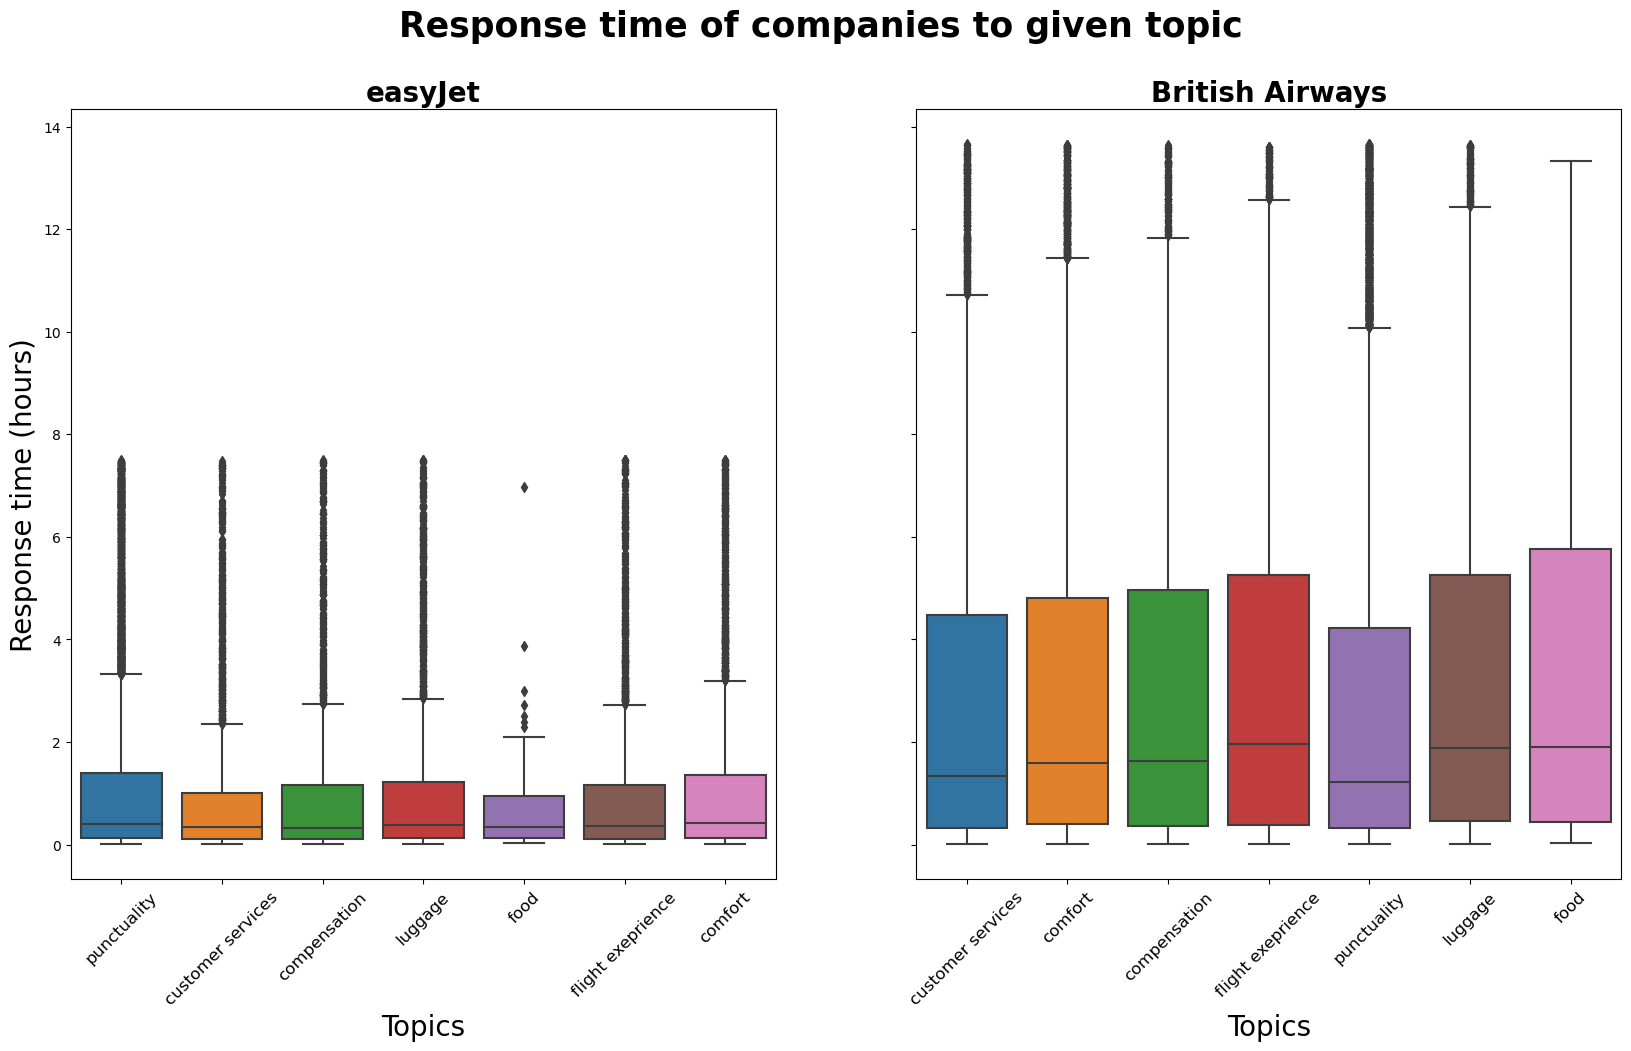

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey = True) ### prototype


sns.boxplot(data= filter_e, x = 'topic', y='time_shift', ax = ax[0])
sns.boxplot(data= filter_b, x = 'topic', y='time_shift', ax = ax[1]);

fig.suptitle('Response time of companies to given topic', size = 25, weight = "bold")

ax[0].set_title("easyJet", size = 20, weight = "bold")
ax[1].set_title("British Airways", size = 20, weight = "bold")

ax[0].set_ylabel("Response time (hours)", size = 20)
ax[1].set_ylabel("")

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, size =12)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, size =12)

ax[0].set_xlabel("Topics", size=20)
ax[1].set_xlabel("Topics", size=20);
 

# Hypothesis testing using welch t-test (variance is not equal)

### H0 : There is no difference in means of response time for chosen topic between easyJet and British Airways.
### H1 : There is difference in means of response time for chosen topic between easyJet and British Airways.

In [104]:
def get_list_sample_means(df, response, data_percent, trials): 
    """
    creates the dataframe with sample means of randomly taken samples
    :param df: dataframe from which we take the compound
    :param compound: the compound that we choose 
    :trials: amount of sample means that we will use for ploting the density plot 
    :return: the dataframe of sample means of randomly taken samples 
    """

    # list which will contain the sample means 
    lst_of_means = []

    # creating the array with random samples from the dataframe and adding their means in to the list above
    # argument for using array - we think that array stores faster

    # creating a loop to provide 'trials' amount of random sampling
    n = 0
    while n < trials:
        array_sample = df[[response]].sample(n=int(df[[response]].count()[0]*data_percent), 
                                                  replace=True).reset_index()[response].to_numpy()
        
        lst_of_means.append(np.mean(array_sample))  # add the mean of the sample in the list
        n += 1

    # here we are creating the dataframe which will include our sample means
    df_sample_means = pd.DataFrame({f'{df.index.to_list()[0]}' :lst_of_means})
 
    return df_sample_means

In [105]:
def hyp_testing(df_EJ, df_BA, topics, data_percent, trials):
    

    hyp_test_df = pd.DataFrame()
    
    for topic in topics:
    
        data_EJ_df = df_EJ.set_index('topic').loc[topic][['time_shift']]
        data_BA_df = df_BA.set_index('topic').loc[topic][['time_shift']]

        samples_EJ_df = get_list_sample_means(data_EJ_df, "time_shift", 0.8, 300)
        samples_BA_df = get_list_sample_means(data_BA_df, "time_shift", 0.8, 300)

        normalized_EJ = sm.stats.normal_ad(samples_EJ_df[topic])[1]
        normalized_BA = sm.stats.normal_ad(samples_BA_df[topic])[1]

        t_stat, p_value = stats.ttest_ind(samples_EJ_df[topic], samples_BA_df[topic], equal_var=False, alternative = 'less')

        row = {"topic" : topic, "easyJet_norm" : normalized_EJ, "BritishAirways_norm" : normalized_BA,
               "t_stat": t_stat, "p_value": p_value}


        hyp_test_df = hyp_test_df.append(row, ignore_index=True)
    
    hyp_test_df = hyp_test_df.set_index('topic')

    return(hyp_test_df)



In [106]:
topics = ["punctuality", "luggage", "food", "flight exeprience", "customer services", "compensation", "comfort"]

In [107]:
hyp_testing_topics_df = hyp_testing(easyJet_topic_df, British_Airways_topic_df, topics, 0.8, 300)
hyp_testing_topics_df

/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3079858848.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyp_test_df = hyp_test_df.append(row, ignore_index=True)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3079858848.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyp_test_df = hyp_test_df.append(row, ignore_index=True)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3079858848.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hyp_test_df = hyp_test_df.append(row, ignore_index=True)
/var/folders/22/gxvfn3cx2_v64ngzhq52h2180000gn/T/ipykernel_61925/3079858848.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fu

,easyJet_norm,BritishAirways_norm,t_stat,p_value
topic,,,,
punctuality,0.503877,0.092463,-713.015756,0.000000e+00
luggage,0.525882,0.652280,-291.149906,0.000000e+00
food,0.013098,0.337482,-83.676507,1.131092e-293
flight exeprience,0.911847,0.895131,-262.535628,0.000000e+00
customer services,0.517440,0.611256,-307.035910,0.000000e+00
compensation,0.863742,0.367249,-310.080187,0.000000e+00
comfort,0.984004,0.899921,-363.895630,0.000000e+00
